
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh <br>
    Adel Movahedian
    400102074

____

# 🔴 **Import Libs**

In [57]:
!pip install torchmetrics
!pip install datasets
!pip install portalocker
!pip install torchtext
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchtext==0.15.2 --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [58]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchtext
from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [59]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.0.1+cu118
0.15.2+cpu


In [60]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.1+cu118
torchtext --> 0.15.2+cpu
tqdm --> 4.66.5


# 🔴 **Utils**

In [61]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [62]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [63]:
from datasets import load_dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [64]:
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer


tokenizer = get_tokenizer("basic_english")

def tokenize_dataset(dataset_split):
    return [tokenizer(line) for line in dataset_split["text"] if line.strip()]

train_tokens = tokenize_dataset(dataset["train"])
valid_tokens = tokenize_dataset(dataset["validation"])
test_tokens = tokenize_dataset(dataset["test"])

token_counter = Counter(token for tokens in train_tokens for token in tokens)


def yield_tokens_with_freq(data_tokens, counter, threshold):
    for tokens in data_tokens:
        yield [token for token in tokens if counter[token] >= threshold]

filtered_tokens = yield_tokens_with_freq(train_tokens, token_counter, 5)

vocab = build_vocab_from_iterator(filtered_tokens, specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

print("Vocabulary size:", len(vocab))
print("Sample tokens from training set:", train_tokens[:2])
print("Filtered token indices for the first training token:", [vocab[token] for token in train_tokens[0] if token in vocab])


Vocabulary size: 20925
Sample tokens from training set: [['=', 'valkyria', 'chronicles', 'iii', '='], ['senjō', 'no', 'valkyria', '3', 'unrecorded', 'chronicles', '(', 'japanese', '戦場のヴァルキュリア3', ',', 'lit', '.', 'valkyria', 'of', 'the', 'battlefield', '3', ')', ',', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', ',', 'is', 'a', 'tactical', 'role', '@-@', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'media', '.', 'vision', 'for', 'the', 'playstation', 'portable', '.', 'released', 'in', 'january', '2011', 'in', 'japan', ',', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'valkyria', 'series', '.', 'employing', 'the', 'same', 'fusion', 'of', 'tactical', 'and', 'real', '@-@', 'time', 'gameplay', 'as', 'its', 'predecessors', ',', 'the', 'story', 'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows', 'the', 'nameless', ',', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the', '

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [65]:
def calculate_statistics(dataset_split):
    total_documents = len(dataset_split["text"])
    total_words = 0
    document_lengths = []

    for line in dataset_split["text"]:
        if line.strip():
            tokens = tokenizer(line)
            total_words += len(tokens)
            document_lengths.append(len(tokens))

    avg_document_length = total_words / total_documents if total_documents > 0 else 0
    return total_documents, total_words, avg_document_length, document_lengths

train_stats = calculate_statistics(dataset["train"])
valid_stats = calculate_statistics(dataset["validation"])
test_stats = calculate_statistics(dataset["test"])

def print_stats(split_name, stats):
    total_documents, total_words, avg_document_length, _ = stats
    print(f"{split_name} Statistics:")
    print(f"  Number of Documents: {total_documents}")
    print(f"  Total Words: {total_words}")
    print(f"  Average Document Length: {avg_document_length:.2f}")
    print()

print_stats("Train", train_stats)
print_stats("Validation", valid_stats)
print_stats("Test", test_stats)

Train Statistics:
  Number of Documents: 36718
  Total Words: 2051665
  Average Document Length: 55.88

Validation Statistics:
  Number of Documents: 3760
  Total Words: 214665
  Average Document Length: 57.09

Test Statistics:
  Number of Documents: 4358
  Total Words: 242156
  Average Document Length: 55.57



### 🟡 Analyze the most common and least common words in the dataset.

In [66]:
def get_word_frequencies(dataset_split):
    word_counter = Counter()

    for line in dataset_split["text"]:
        if line.strip():
            tokens = tokenizer(line)
            word_counter.update(tokens)

    return word_counter

word_frequencies = get_word_frequencies(dataset["train"])
most_common_words = word_frequencies.most_common(10)

least_common_words = [word for word, freq in word_frequencies.items() if freq == 1][:10]
print("Most Common Words:")
for word, freq in most_common_words:
    print(f"  {word}: {freq}")

print("\nLeast Common Words:")
for word in least_common_words:
    print(f"  {word}: 1")

Most Common Words:
  the: 130770
  ,: 102624
  .: 84291
  of: 57032
  and: 50736
  in: 45018
  to: 39522
  a: 36564
  =: 29570
  was: 21008

Least Common Words:
  calamaty: 1
  forgiving: 1
  unvoiced: 1
  scanned: 1
  boosts: 1
  depleting: 1
  reila: 1
  shocktroopers: 1
  thereon: 1
  altaha: 1


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

Number of Rare Words: 26924


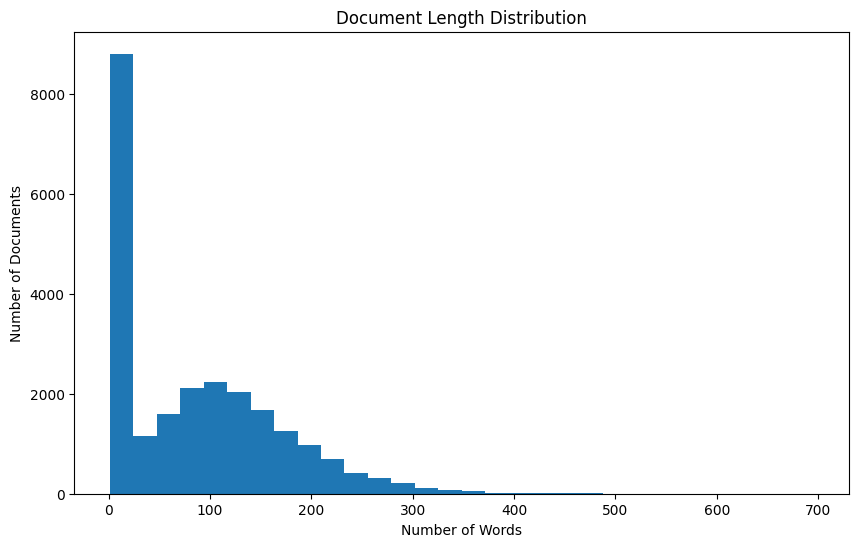

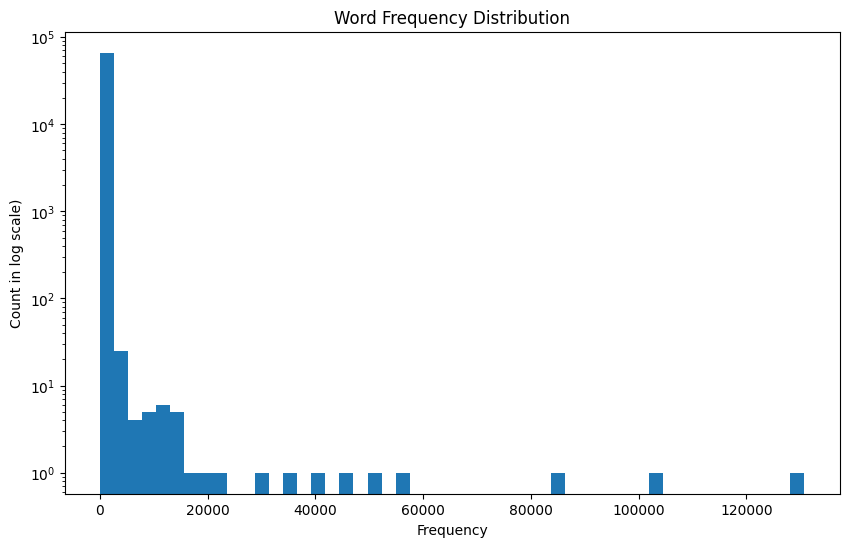

In [67]:
from collections import Counter
word_counts = Counter()
for tokens in train_tokens:
    word_counts.update(tokens)
rare_words = [word for word, count in word_counts.items() if count == 1]
print(f"Number of Rare Words: {len(rare_words)}")
# distributaion
document_lengths = [len(tokens) for tokens in train_tokens]
# document lengths
plt.figure(figsize=(10, 6))
plt.hist(document_lengths, bins=30)
plt.title("Document Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()
# word frequencies
frequencies = list(word_counts.values())
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=50, log=True)
plt.title("Word Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count in log scale)")
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [68]:
def data_process(raw_text_iter, vocab, tokenizer, batch_size, seq_len):
    tokens = [vocab[token] for line in raw_text_iter for token in tokenizer(line) if line.strip()]
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    total_tokens = (token_tensor.size(0) // (batch_size * seq_len)) * (batch_size * seq_len)
    token_tensor = token_tensor[:total_tokens]
    token_tensor = token_tensor.view(batch_size, -1)
    inputs = token_tensor[:, :-1]  # Excluding last token
    targets = token_tensor[:, 1:]  # Shifted inputs
    inputs = inputs[:, :-(inputs.size(1) % seq_len)].view(batch_size, -1, seq_len).permute(1, 0, 2)
    targets = targets[:, :-(targets.size(1) % seq_len)].view(batch_size, -1, seq_len).permute(1, 0, 2)
    return inputs, targets


In [69]:
def prepare_datasets(train_iter, valid_iter, test_iter, vocab, tokenizer, batch_size, seq_len):
    train_inputs, train_targets = data_process(train_iter, vocab, tokenizer, batch_size, seq_len)
    valid_inputs, valid_targets = data_process(valid_iter, vocab, tokenizer, batch_size, seq_len)
    test_inputs, test_targets = data_process(test_iter, vocab, tokenizer, batch_size, seq_len)
    return (train_inputs, train_targets), (valid_inputs, valid_targets), (test_inputs, test_targets)
batch_size = 32
seq_len = 20
(train_inputs, train_targets), (valid_inputs, valid_targets), (test_inputs, test_targets) = prepare_datasets(
    train_iter=dataset["train"]["text"],
    valid_iter=dataset["validation"]["text"],
    test_iter=dataset["test"]["text"],
    vocab=vocab,
    tokenizer=tokenizer,
    batch_size=batch_size,
    seq_len=seq_len
)

print(train_inputs.shape)
print(valid_inputs.shape)
print(test_inputs.shape)


torch.Size([3204, 32, 20])
torch.Size([334, 32, 20])
torch.Size([377, 32, 20])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [70]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


In [71]:
train_dataset = LanguageModelDataset(train_inputs, train_targets)
valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
test_dataset = LanguageModelDataset(test_inputs, test_targets)

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [72]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

<font color='green'> I set the batch size to 1 in the DataLoader so it ensures that each batch corresponds to one complete (B, L) group of sequences</font>

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [73]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super(LanguageModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
    self.fc = nn.Linear(hidden_dim, vocab_size)
    self.dropout = nn.Dropout(dropout_rate)
  def forward(self, src):
    embedded = self.embedding(src)
    embedded = self.dropout(embedded)
    lstm_out, _ = self.lstm(embedded)
    output = self.fc(lstm_out)
    return output


In [74]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 512
num_layers = 3
dropout_rate = 0.5

model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

# 🔴 **Config**

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [76]:
from torchmetrics import Accuracy
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metric = Accuracy(task="multiclass", num_classes=vocab_size).to(device)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [77]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.squeeze(0).to(device)  #(B, L)
      targets = targets.squeeze(0).to(device)  #(B, L)

      outputs = model(inputs)
      targets = targets.view(-1)
      outputs = outputs.view(-1, outputs.size(-1))

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [78]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.squeeze(0).to(device)  #(B, L)
      targets = targets.squeeze(0).to(device)  #(B, L)
      outputs = model(inputs)
      targets = targets.view(-1)
      outputs = outputs.view(-1, outputs.size(-1))
      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [79]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

inputs, targets = next(iter(train_loader))  #(1, B, L)
inputs = inputs.squeeze(0).to(device)       #(B, L)
targets = targets.squeeze(0).to(device)

with torch.no_grad():
  outputs = model(inputs)
  outputs = outputs.view(-1, outputs.size(-1))
  targets = targets.view(-1)
  loss = loss_fn(outputs, targets)
print(loss)

tensor(9.9436, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [80]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [81]:
loss_fn = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=vocab_size).to(device)
small_train_inputs = train_inputs[:5]
small_train_targets = train_targets[:5]
small_train_dataset = LanguageModelDataset(small_train_inputs, small_train_targets)
small_train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=False)

In [82]:
num_epochs = 20
for epoch in range(num_epochs):
    model, avg_loss, train_accuracy = train_one_epoch(
        model=model,
        train_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epoch=epoch
    )
    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {train_accuracy:.4f}")

100%|██████████| 3204/3204 [00:59<00:00, 53.53batch/s, loss=6.62, metric=0.105] 


Epoch 1: Loss = 6.6203, Accuracy = 0.1046


Epoch 1: 100%|██████████| 3204/3204 [01:02<00:00, 50.89batch/s, loss=6.14, metric=0.148]


Epoch 2: Loss = 6.1414, Accuracy = 0.1479


Epoch 2: 100%|██████████| 3204/3204 [01:02<00:00, 50.88batch/s, loss=5.97, metric=0.158]


Epoch 3: Loss = 5.9700, Accuracy = 0.1579


Epoch 3: 100%|██████████| 3204/3204 [01:02<00:00, 50.86batch/s, loss=5.86, metric=0.164]


Epoch 4: Loss = 5.8621, Accuracy = 0.1637


Epoch 4: 100%|██████████| 3204/3204 [01:02<00:00, 50.88batch/s, loss=5.78, metric=0.168]


Epoch 5: Loss = 5.7808, Accuracy = 0.1681


Epoch 5: 100%|██████████| 3204/3204 [01:02<00:00, 50.91batch/s, loss=5.71, metric=0.171]


Epoch 6: Loss = 5.7142, Accuracy = 0.1712


Epoch 6: 100%|██████████| 3204/3204 [01:03<00:00, 50.84batch/s, loss=5.66, metric=0.174]


Epoch 7: Loss = 5.6571, Accuracy = 0.1741


Epoch 7: 100%|██████████| 3204/3204 [01:02<00:00, 50.88batch/s, loss=5.61, metric=0.177]


Epoch 8: Loss = 5.6061, Accuracy = 0.1766


Epoch 8: 100%|██████████| 3204/3204 [01:03<00:00, 50.85batch/s, loss=5.56, metric=0.179]


Epoch 9: Loss = 5.5608, Accuracy = 0.1788


Epoch 9: 100%|██████████| 3204/3204 [01:02<00:00, 50.87batch/s, loss=5.52, metric=0.181]


Epoch 10: Loss = 5.5195, Accuracy = 0.1806


Epoch 10: 100%|██████████| 3204/3204 [01:03<00:00, 50.85batch/s, loss=5.48, metric=0.182]


Epoch 11: Loss = 5.4810, Accuracy = 0.1825


Epoch 11: 100%|██████████| 3204/3204 [01:03<00:00, 50.79batch/s, loss=5.45, metric=0.184]


Epoch 12: Loss = 5.4454, Accuracy = 0.1842


Epoch 12: 100%|██████████| 3204/3204 [01:03<00:00, 50.57batch/s, loss=5.41, metric=0.186]


Epoch 13: Loss = 5.4118, Accuracy = 0.1857


Epoch 13: 100%|██████████| 3204/3204 [01:03<00:00, 50.83batch/s, loss=5.38, metric=0.187]


Epoch 14: Loss = 5.3805, Accuracy = 0.1871


Epoch 14: 100%|██████████| 3204/3204 [01:03<00:00, 50.79batch/s, loss=5.35, metric=0.188]


Epoch 15: Loss = 5.3503, Accuracy = 0.1881


Epoch 15: 100%|██████████| 3204/3204 [01:03<00:00, 50.81batch/s, loss=5.32, metric=0.189]


Epoch 16: Loss = 5.3220, Accuracy = 0.1892


Epoch 16: 100%|██████████| 3204/3204 [01:03<00:00, 50.82batch/s, loss=5.29, metric=0.191]


Epoch 17: Loss = 5.2950, Accuracy = 0.1905


Epoch 17: 100%|██████████| 3204/3204 [01:03<00:00, 50.85batch/s, loss=5.27, metric=0.191]


Epoch 18: Loss = 5.2690, Accuracy = 0.1915


Epoch 18: 100%|██████████| 3204/3204 [01:03<00:00, 50.85batch/s, loss=5.24, metric=0.193]


Epoch 19: Loss = 5.2425, Accuracy = 0.1927


Epoch 19: 100%|██████████| 3204/3204 [01:03<00:00, 50.79batch/s, loss=5.22, metric=0.194]

Epoch 20: Loss = 5.2187, Accuracy = 0.1935


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [83]:
import torch.optim as optim
learning_rates = [0.01, 0.05, 0.1]
num_epochs = 10

for lr in learning_rates:
    print(f"Testing Learning Rate: {lr}")
    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
    for epoch in range(num_epochs):
        model, avg_loss, train_accuracy = train_one_epoch(
            model=model,
            train_loader=small_train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            metric=metric,
            epoch=epoch
        )
        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {train_accuracy:.4f}")
    print()#next line


Testing Learning Rate: 0.01


100%|██████████| 5/5 [00:00<00:00, 53.17batch/s, loss=9.95, metric=0]


Epoch 1: Loss = 9.9476, Accuracy = 0.0000


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.88batch/s, loss=9.94, metric=0]


Epoch 2: Loss = 9.9435, Accuracy = 0.0000


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 49.53batch/s, loss=9.94, metric=0.00875]


Epoch 3: Loss = 9.9372, Accuracy = 0.0088


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 49.33batch/s, loss=9.93, metric=0.0391]


Epoch 4: Loss = 9.9292, Accuracy = 0.0391


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 49.51batch/s, loss=9.92, metric=0.0434]


Epoch 5: Loss = 9.9203, Accuracy = 0.0434


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 49.46batch/s, loss=9.91, metric=0.0569]


Epoch 6: Loss = 9.9111, Accuracy = 0.0569


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 50.00batch/s, loss=9.9, metric=0.0647]


Epoch 7: Loss = 9.9015, Accuracy = 0.0647


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 50.34batch/s, loss=9.89, metric=0.0644]


Epoch 8: Loss = 9.8917, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 50.45batch/s, loss=9.88, metric=0.0644]


Epoch 9: Loss = 9.8815, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 51.04batch/s, loss=9.87, metric=0.0644]


Epoch 10: Loss = 9.8712, Accuracy = 0.0644

Testing Learning Rate: 0.05


100%|██████████| 5/5 [00:00<00:00, 53.39batch/s, loss=9.94, metric=0.00219]


Epoch 1: Loss = 9.9397, Accuracy = 0.0022


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.85batch/s, loss=9.92, metric=0.0641]


Epoch 2: Loss = 9.9199, Accuracy = 0.0641


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 50.74batch/s, loss=9.89, metric=0.0644]


Epoch 3: Loss = 9.8876, Accuracy = 0.0644


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 50.98batch/s, loss=9.85, metric=0.0644]


Epoch 4: Loss = 9.8472, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 50.77batch/s, loss=9.8, metric=0.0644]


Epoch 5: Loss = 9.7991, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 50.82batch/s, loss=9.74, metric=0.0644]


Epoch 6: Loss = 9.7431, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 50.64batch/s, loss=9.67, metric=0.0644]


Epoch 7: Loss = 9.6749, Accuracy = 0.0644


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 50.76batch/s, loss=9.59, metric=0.0644]


Epoch 8: Loss = 9.5858, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 50.34batch/s, loss=9.46, metric=0.0644]


Epoch 9: Loss = 9.4569, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 50.04batch/s, loss=9.24, metric=0.0644]


Epoch 10: Loss = 9.2408, Accuracy = 0.0644

Testing Learning Rate: 0.1


100%|██████████| 5/5 [00:00<00:00, 51.49batch/s, loss=9.94, metric=0.00938]


Epoch 1: Loss = 9.9434, Accuracy = 0.0094


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 48.52batch/s, loss=9.9, metric=0.0644]


Epoch 2: Loss = 9.9045, Accuracy = 0.0644


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 48.75batch/s, loss=9.84, metric=0.0644]


Epoch 3: Loss = 9.8392, Accuracy = 0.0644


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 49.07batch/s, loss=9.75, metric=0.0644]


Epoch 4: Loss = 9.7493, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 48.97batch/s, loss=9.62, metric=0.0644]


Epoch 5: Loss = 9.6219, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 48.80batch/s, loss=9.41, metric=0.0644]


Epoch 6: Loss = 9.4070, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 48.23batch/s, loss=8.92, metric=0.0644]


Epoch 7: Loss = 8.9202, Accuracy = 0.0644


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 48.82batch/s, loss=8.29, metric=0.0613]


Epoch 8: Loss = 8.2937, Accuracy = 0.0613


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 48.63batch/s, loss=7.96, metric=0.0378]


Epoch 9: Loss = 7.9606, Accuracy = 0.0378


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 49.07batch/s, loss=7.79, metric=0.0325]

Epoch 10: Loss = 7.7895, Accuracy = 0.0325



### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [84]:
best_lr = 0.05
weight_decays = [0, 1e-4, 1e-3, 1e-2]
num_epochs = 10

for lr in [best_lr]:
    for wd in weight_decays:
        print(f"Testing Grid: LR={lr}, WD={wd}")
        model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

        for epoch in range(num_epochs):
            model, avg_loss, train_accuracy = train_one_epoch(
                model=model,
                train_loader=small_train_loader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                metric=metric,
                epoch=epoch
            )
            print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {train_accuracy:.4f}")

        print()


Testing Grid: LR=0.05, WD=0


100%|██████████| 5/5 [00:00<00:00, 52.20batch/s, loss=9.95, metric=0]


Epoch 1: Loss = 9.9468, Accuracy = 0.0000


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 51.06batch/s, loss=9.93, metric=0.0569]


Epoch 2: Loss = 9.9269, Accuracy = 0.0569


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 52.61batch/s, loss=9.89, metric=0.0644]


Epoch 3: Loss = 9.8947, Accuracy = 0.0644


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 52.15batch/s, loss=9.85, metric=0.0644]


Epoch 4: Loss = 9.8541, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 51.80batch/s, loss=9.81, metric=0.0644]


Epoch 5: Loss = 9.8062, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 51.85batch/s, loss=9.75, metric=0.0644]


Epoch 6: Loss = 9.7501, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 51.70batch/s, loss=9.68, metric=0.0644]

Epoch 7: Loss = 9.6820, Accuracy = 0.0644



Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 52.34batch/s, loss=9.59, metric=0.0644]


Epoch 8: Loss = 9.5930, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 52.08batch/s, loss=9.47, metric=0.0644]


Epoch 9: Loss = 9.4652, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 52.39batch/s, loss=9.25, metric=0.0644]


Epoch 10: Loss = 9.2534, Accuracy = 0.0644

Testing Grid: LR=0.05, WD=0.0001


100%|██████████| 5/5 [00:00<00:00, 53.21batch/s, loss=9.94, metric=0.000312]


Epoch 1: Loss = 9.9434, Accuracy = 0.0003


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.94batch/s, loss=9.92, metric=0.04]


Epoch 2: Loss = 9.9241, Accuracy = 0.0400


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 50.48batch/s, loss=9.89, metric=0.0637]


Epoch 3: Loss = 9.8918, Accuracy = 0.0637


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 50.02batch/s, loss=9.85, metric=0.0644]


Epoch 4: Loss = 9.8510, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 50.22batch/s, loss=9.8, metric=0.0644]


Epoch 5: Loss = 9.8026, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 50.75batch/s, loss=9.74, metric=0.0644]


Epoch 6: Loss = 9.7447, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 50.63batch/s, loss=9.67, metric=0.0644]


Epoch 7: Loss = 9.6731, Accuracy = 0.0644


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 51.21batch/s, loss=9.58, metric=0.0644]


Epoch 8: Loss = 9.5774, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 50.20batch/s, loss=9.43, metric=0.0644]


Epoch 9: Loss = 9.4350, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 48.16batch/s, loss=9.19, metric=0.0644]


Epoch 10: Loss = 9.1895, Accuracy = 0.0644

Testing Grid: LR=0.05, WD=0.001


100%|██████████| 5/5 [00:00<00:00, 51.30batch/s, loss=9.94, metric=0.000312]


Epoch 1: Loss = 9.9420, Accuracy = 0.0003


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 48.89batch/s, loss=9.92, metric=0.045]


Epoch 2: Loss = 9.9230, Accuracy = 0.0450


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 49.11batch/s, loss=9.89, metric=0.0644]


Epoch 3: Loss = 9.8909, Accuracy = 0.0644


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 48.42batch/s, loss=9.85, metric=0.0644]


Epoch 4: Loss = 9.8510, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 48.56batch/s, loss=9.8, metric=0.0644]


Epoch 5: Loss = 9.8039, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 50.66batch/s, loss=9.75, metric=0.0644]


Epoch 6: Loss = 9.7488, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 50.65batch/s, loss=9.68, metric=0.0644]


Epoch 7: Loss = 9.6818, Accuracy = 0.0644


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 51.02batch/s, loss=9.6, metric=0.0644]


Epoch 8: Loss = 9.5953, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 50.78batch/s, loss=9.47, metric=0.0644]


Epoch 9: Loss = 9.4722, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 51.10batch/s, loss=9.27, metric=0.0644]


Epoch 10: Loss = 9.2700, Accuracy = 0.0644

Testing Grid: LR=0.05, WD=0.01


100%|██████████| 5/5 [00:00<00:00, 53.70batch/s, loss=9.94, metric=0]


Epoch 1: Loss = 9.9447, Accuracy = 0.0000


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 50.73batch/s, loss=9.92, metric=0.06]


Epoch 2: Loss = 9.9249, Accuracy = 0.0600


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 50.46batch/s, loss=9.89, metric=0.0644]


Epoch 3: Loss = 9.8935, Accuracy = 0.0644


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 51.23batch/s, loss=9.85, metric=0.0644]


Epoch 4: Loss = 9.8548, Accuracy = 0.0644


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 51.05batch/s, loss=9.81, metric=0.0644]


Epoch 5: Loss = 9.8109, Accuracy = 0.0644


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 50.99batch/s, loss=9.76, metric=0.0644]


Epoch 6: Loss = 9.7616, Accuracy = 0.0644


Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 50.98batch/s, loss=9.7, metric=0.0644]


Epoch 7: Loss = 9.7049, Accuracy = 0.0644


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 50.84batch/s, loss=9.64, metric=0.0644]


Epoch 8: Loss = 9.6366, Accuracy = 0.0644


Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 50.96batch/s, loss=9.55, metric=0.0644]


Epoch 9: Loss = 9.5479, Accuracy = 0.0644


Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 50.96batch/s, loss=9.42, metric=0.0644]


Epoch 10: Loss = 9.4200, Accuracy = 0.0644



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [85]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

In [86]:
lr = 0.05
wd = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [87]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [88]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f"Epoch {epoch + 1}/{num_epochs}:")
  print(f"  Train: Loss = {loss_train:.4f}, Metric = {metric_train:.4f}")
  print(f"  Valid: Loss = {loss_valid:.4f}, Metric = {metric_valid:.4f}")
  print()

  epoch_counter += 1

100%|██████████| 3204/3204 [01:02<00:00, 51.06batch/s, loss=6.94, metric=0.0629]


Model Saved!
Epoch 1/20:
  Train: Loss = 6.9437, Metric = 0.0629
  Valid: Loss = 6.5818, Metric = 0.0915



Epoch 11: 100%|██████████| 3204/3204 [01:05<00:00, 48.61batch/s, loss=6.22, metric=0.149]


Model Saved!
Epoch 12/20:
  Train: Loss = 6.2188, Metric = 0.1492
  Valid: Loss = 6.0198, Metric = 0.1640



Epoch 12: 100%|██████████| 3204/3204 [01:05<00:00, 48.62batch/s, loss=6.19, metric=0.153]


Model Saved!
Epoch 13/20:
  Train: Loss = 6.1877, Metric = 0.1535
  Valid: Loss = 5.9866, Metric = 0.1694



Epoch 13: 100%|██████████| 3204/3204 [01:05<00:00, 48.63batch/s, loss=6.17, metric=0.156]


Epoch 14/20:
  Train: Loss = 6.1698, Metric = 0.1561
  Valid: Loss = 6.0138, Metric = 0.1636



Epoch 14: 100%|██████████| 3204/3204 [01:05<00:00, 48.59batch/s, loss=6.16, metric=0.157]


Model Saved!
Epoch 15/20:
  Train: Loss = 6.1582, Metric = 0.1573
  Valid: Loss = 5.9572, Metric = 0.1709



Epoch 15: 100%|██████████| 3204/3204 [01:05<00:00, 48.56batch/s, loss=6.15, metric=0.158]


Epoch 16/20:
  Train: Loss = 6.1496, Metric = 0.1583
  Valid: Loss = 5.9617, Metric = 0.1702



Epoch 16: 100%|██████████| 3204/3204 [01:05<00:00, 48.62batch/s, loss=6.14, metric=0.159]


Epoch 17/20:
  Train: Loss = 6.1442, Metric = 0.1587
  Valid: Loss = 5.9839, Metric = 0.1703



Epoch 17: 100%|██████████| 3204/3204 [01:05<00:00, 48.63batch/s, loss=6.14, metric=0.159]


Epoch 18/20:
  Train: Loss = 6.1394, Metric = 0.1592
  Valid: Loss = 5.9629, Metric = 0.1693



Epoch 18: 100%|██████████| 3204/3204 [01:05<00:00, 48.58batch/s, loss=6.14, metric=0.16] 


Model Saved!
Epoch 19/20:
  Train: Loss = 6.1352, Metric = 0.1596
  Valid: Loss = 5.9473, Metric = 0.1735



Epoch 19: 100%|██████████| 3204/3204 [01:05<00:00, 48.59batch/s, loss=6.13, metric=0.16] 


Epoch 20/20:
  Train: Loss = 6.1321, Metric = 0.1597
  Valid: Loss = 5.9498, Metric = 0.1707



## 🟠 Main Loop

🔰 Define model.

In [90]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)
model = model.to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [91]:
lr =0.05
wd =1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [92]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model=model,
                                                 train_loader=train_loader,
                                                 loss_fn=loss_fn,
                                                 optimizer=optimizer,
                                                 metric=metric,
                                                 epoch=epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model=model,
                                     test_loader=valid_loader,
                                     loss_fn=loss_fn,
                                     metric=metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 3204/3204 [01:01<00:00, 51.82batch/s, loss=6.82, metric=0.0828]


Model Saved!
Valid: Loss = 6.288, Metric = 0.1299



Epoch 1: 100%|██████████| 3204/3204 [01:05<00:00, 49.24batch/s, loss=6.35, metric=0.135]


Model Saved!
Valid: Loss = 6.029, Metric = 0.1562



Epoch 2: 100%|██████████| 3204/3204 [01:04<00:00, 49.38batch/s, loss=6.17, metric=0.148]


Model Saved!
Valid: Loss = 5.907, Metric = 0.1643



Epoch 3: 100%|██████████| 3204/3204 [01:04<00:00, 49.34batch/s, loss=6.07, metric=0.154]


Model Saved!
Valid: Loss = 5.82, Metric = 0.1703



Epoch 4: 100%|██████████| 3204/3204 [01:04<00:00, 49.43batch/s, loss=5.99, metric=0.158]


Model Saved!
Valid: Loss = 5.757, Metric = 0.1746



Epoch 5: 100%|██████████| 3204/3204 [01:04<00:00, 49.40batch/s, loss=5.93, metric=0.162]


Model Saved!
Valid: Loss = 5.708, Metric = 0.1778



Epoch 6: 100%|██████████| 3204/3204 [01:04<00:00, 49.40batch/s, loss=5.87, metric=0.165]


Model Saved!
Valid: Loss = 5.663, Metric = 0.1801



Epoch 7: 100%|██████████| 3204/3204 [01:04<00:00, 49.40batch/s, loss=5.83, metric=0.167]


Model Saved!
Valid: Loss = 5.626, Metric = 0.1845



Epoch 8: 100%|██████████| 3204/3204 [01:04<00:00, 49.43batch/s, loss=5.79, metric=0.169]


Model Saved!
Valid: Loss = 5.601, Metric = 0.1848



Epoch 9: 100%|██████████| 3204/3204 [01:04<00:00, 49.42batch/s, loss=5.75, metric=0.171]


Model Saved!
Valid: Loss = 5.565, Metric = 0.1879



Epoch 10: 100%|██████████| 3204/3204 [01:04<00:00, 49.37batch/s, loss=5.72, metric=0.173]


Model Saved!
Valid: Loss = 5.544, Metric = 0.1895



Epoch 11: 100%|██████████| 3204/3204 [01:04<00:00, 49.37batch/s, loss=5.69, metric=0.174]


Model Saved!
Valid: Loss = 5.519, Metric = 0.1907



Epoch 12: 100%|██████████| 3204/3204 [01:05<00:00, 49.18batch/s, loss=5.66, metric=0.176]


Model Saved!
Valid: Loss = 5.503, Metric = 0.1921



Epoch 13: 100%|██████████| 3204/3204 [01:04<00:00, 49.33batch/s, loss=5.63, metric=0.177]


Model Saved!
Valid: Loss = 5.487, Metric = 0.1931



Epoch 14: 100%|██████████| 3204/3204 [01:04<00:00, 49.31batch/s, loss=5.61, metric=0.178]


Model Saved!
Valid: Loss = 5.463, Metric = 0.1954



Epoch 15: 100%|██████████| 3204/3204 [01:05<00:00, 49.26batch/s, loss=5.59, metric=0.18] 


Model Saved!
Valid: Loss = 5.455, Metric = 0.1949



Epoch 16: 100%|██████████| 3204/3204 [01:05<00:00, 49.20batch/s, loss=5.56, metric=0.181]


Model Saved!
Valid: Loss = 5.435, Metric = 0.1972



Epoch 17: 100%|██████████| 3204/3204 [01:04<00:00, 49.33batch/s, loss=5.54, metric=0.182]


Model Saved!
Valid: Loss = 5.425, Metric = 0.198



Epoch 18: 100%|██████████| 3204/3204 [01:04<00:00, 49.40batch/s, loss=5.52, metric=0.183]


Model Saved!
Valid: Loss = 5.41, Metric = 0.1992



Epoch 35: 100%|██████████| 3204/3204 [01:04<00:00, 49.60batch/s, loss=5.28, metric=0.196]


Model Saved!
Valid: Loss = 5.283, Metric = 0.208



Epoch 40: 100%|██████████| 3204/3204 [01:04<00:00, 49.52batch/s, loss=5.22, metric=0.198]


Model Saved!
Valid: Loss = 5.258, Metric = 0.2104



Epoch 43: 100%|██████████| 3204/3204 [01:05<00:00, 49.00batch/s, loss=5.19, metric=0.2]


Model Saved!
Valid: Loss = 5.246, Metric = 0.2125



Epoch 45: 100%|██████████| 3204/3204 [01:04<00:00, 49.35batch/s, loss=5.17, metric=0.201]


Model Saved!
Valid: Loss = 5.242, Metric = 0.2115



Epoch 47: 100%|██████████| 3204/3204 [01:04<00:00, 49.37batch/s, loss=5.15, metric=0.202]


Model Saved!
Valid: Loss = 5.239, Metric = 0.2123



Epoch 48:  32%|███▏      | 1041/3204 [00:21<00:43, 49.37batch/s, loss=5.13, metric=0.203]

<font color='green'>kaggle didn't do it for the whole epoches as you see it skipt some of them and didn't made to the end and our model is half trained , with metric about 0.21 .(As discussed there is no problem with this)</font>

## 🟠 Plot

🔰 Plot learning curves

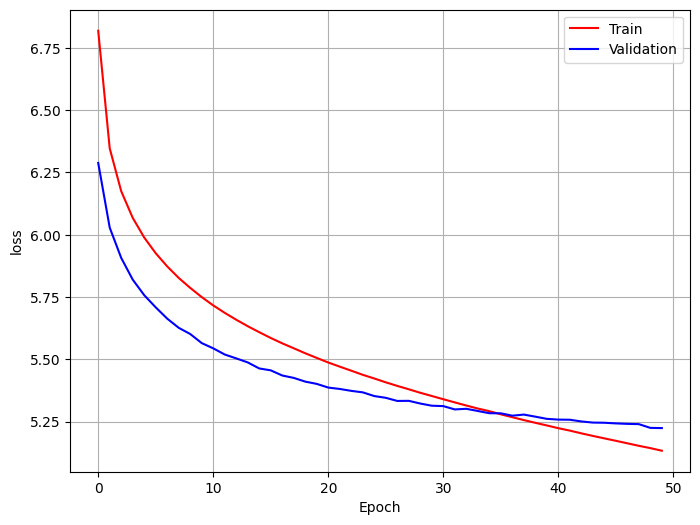

In [94]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [96]:
model = model.to(device)
test_loss, test_metric = evaluate(
    model=model,
    test_loader=test_loader,
    loss_fn=loss_fn,
    metric=metric,
)
print(f"Test Results: Loss = {test_loss:.4f}, Accuracy = {test_metric:.4f}")

Test Results: Loss = 5.1436, Accuracy = 0.2144


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [97]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(20925, 128)
  (lstm): LSTM(128, 512, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=20925, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [108]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    model.eval()
    input_tokens = tokenizer(prompt)
    input_ids = torch.tensor([vocab[token] for token in input_tokens], dtype=torch.long).unsqueeze(0).to(device)
    generated_ids = input_ids
    for _ in range(max_seq_len):
        with torch.no_grad():
            outputs = model(generated_ids)
            logits = outputs[:, -1, :] 

        logits = logits / temperature
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probabilities, num_samples=1).squeeze(-1)

        next_token_id = next_token_id.unsqueeze(0)
        generated_ids = torch.cat([generated_ids, next_token_id], dim=1)
        if next_token_id.item() == vocab['<eos>']:
            break
    generated_tokens = [vocab.lookup_token(token_id) for token_id in generated_ids.squeeze(0).tolist()]
    return " ".join(generated_tokens)


In [119]:
model = model.to(device)
model.eval()

prompt = "my head hearts and"
max_seq_len = 8
temperature = 1.0
generated_text = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab)
print("Generated Text:")
print(generated_text)


Generated Text:
my head hearts and pathogenic . art began on an remarkable tour


<font color ='green'>As we can see the model is not optimized because it should be trained very much to generate more suitable answers.If we had GPUs available I think there would be some chances to have a very good generator model.</font>